# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import json
import typing as t
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias = pd.read_csv('./data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('./data/Udacity_CUSTOMERS_052018.csv', sep=';')

/Users/boonchuay/Library/Python/3.7/lib/python/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# specify path and filename for metadata
MET_DIR = Path('./metadata')
MET_FILENAMES = ['age-data.json', 'interval-data.json', 'nominal-data.json', 'ordinal-data.json']

# load json file to metadata dict
metadata = {}

for file_ in MET_FILENAMES:
    with open(MET_DIR / file_, 'r') as fp:
        print('load --> ', file_.replace('.json', ''))
        metadata[file_.replace('.json', '')] = json.load(fp)

load -->  age-data
load -->  interval-data
load -->  nominal-data
load -->  ordinal-data


## Check consistency in metadata file feature description and existing feature in raw data

In [4]:
def check_containment(metadata, df):
    '''check that all column in metadata is existed
    '''
    not_contains = []

    for data_type, metas in metadata.items():
        print(f'===={data_type}====')

        for meta in metas:
            feature = meta['feature']

            if feature not in df.columns:
                print(feature)
                not_contains.append(feature)

    return not_contains

def check_containment_reverse(metada, df):
    '''Check that all column in df are exist in metada
    '''

    meta_features = []

    for data_type, metas in metadata.items():

        for meta in metas:
            feature = meta['feature']
            meta_features.append(feature)

    print(len(meta_features))
    not_contains = []
    for feature in df.columns:
        if feature not in meta_features:
            print(feature)
            not_contains.append(feature)

    return not_contains


In [5]:
data_not_contains = check_containment(metadata, azdias)

====age-data====
====interval-data====
====nominal-data====
SOHO_FLAG
HAUSHALTSSTRUKTUR
BIP_FLAG
CAMEO_DEUINTL_2015
====ordinal-data====
WACHSTUMSGEBIET_NB
GEOSCORE_KLS7


In [6]:
meta_not_contains = check_containment_reverse(metadata, azdias)

205
LNR
AKT_DAT_KL
ALTER_KIND1
ALTER_KIND2
ALTER_KIND3
ALTER_KIND4
ALTERSKATEGORIE_FEIN
ANZ_KINDER
ANZ_STATISTISCHE_HAUSHALTE
ARBEIT
CAMEO_INTL_2015
CJT_KATALOGNUTZER
CJT_TYP_1
CJT_TYP_2
CJT_TYP_3
CJT_TYP_4
CJT_TYP_5
CJT_TYP_6
D19_BUCH_CD
D19_KONSUMTYP_MAX
D19_LETZTER_KAUF_BRANCHE
D19_SOZIALES
D19_TELKO_ONLINE_QUOTE_12
D19_VERSI_DATUM
D19_VERSI_OFFLINE_DATUM
D19_VERSI_ONLINE_DATUM
D19_VERSI_ONLINE_QUOTE_12
DSL_FLAG
EINGEFUEGT_AM
EINGEZOGENAM_HH_JAHR
EXTSEL992
FIRMENDICHTE
GEMEINDETYP
HH_DELTA_FLAG
KBA13_ALTERHALTER_30
KBA13_ALTERHALTER_45
KBA13_ALTERHALTER_60
KBA13_ALTERHALTER_61
KBA13_ANTG1
KBA13_ANTG2
KBA13_ANTG3
KBA13_ANTG4
KBA13_AUDI
KBA13_AUTOQUOTE
KBA13_BAUMAX
KBA13_BJ_1999
KBA13_BJ_2000
KBA13_BJ_2004
KBA13_BJ_2006
KBA13_BJ_2008
KBA13_BJ_2009
KBA13_BMW
KBA13_CCM_0_1400
KBA13_CCM_1000
KBA13_CCM_1200
KBA13_CCM_1400
KBA13_CCM_1401_2500
KBA13_CCM_1500
KBA13_CCM_1600
KBA13_CCM_1800
KBA13_CCM_2000
KBA13_CCM_2500
KBA13_CCM_2501
KBA13_CCM_3000
KBA13_CCM_3001
KBA13_FAB_ASIEN
KBA13_FAB_SON

From the above information, we can see that there are many features in metadata file (which extract from DIAS Attributes file) that are not exist in azdias's columns.  

Many features in azdias's columns are, also, not exist in metadata file. Without a description I can not know the meaning of the features, so I consider drop all the features that are not exist in metadata file.

In [7]:
def get_all_exist_feature(metadata, data_not_contains):
    '''Get all feature names from metadata file
    '''
    
    all_feature = []

    for features in [*map(lambda key: metadata[key], metadata)]:
        for feature in features:
            feature_name = feature['feature']
            all_feature.append(feature_name)

    all_feature_contains = list(set(all_feature) - set(data_not_contains))
    return all_feature_contains

In [8]:
all_feature_contains = get_all_exist_feature(metadata, data_not_contains)

In [9]:
print(all_feature_contains)

['KBA05_MAXBJ', 'KBA05_MOD4', 'SEMIO_FAM', 'KBA05_MOD3', 'KBA05_SEG8', 'KBA05_SEG5', 'D19_BANKEN_REST', 'D19_VERSAND_ANZ_12', 'FINANZ_SPARER', 'D19_RATGEBER', 'WOHNLAGE', 'KBA05_CCM3', 'FINANZ_ANLEGER', 'KKK', 'WOHNDAUER_2008', 'SEMIO_RAT', 'KBA05_MOD2', 'KBA05_VORB0', 'D19_LOTTO', 'KBA05_ZUL4', 'D19_TELKO_ONLINE_DATUM', 'KBA05_HERST2', 'D19_HANDWERK', 'D19_GESAMT_ONLINE_QUOTE_12', 'LP_STATUS_FEIN', 'CAMEO_DEU_2015', 'FINANZ_HAUSBAUER', 'D19_SONSTIGE', 'D19_VERSAND_DATUM', 'KBA05_ANTG3', 'KBA05_GBZ', 'D19_BEKLEIDUNG_GEH', 'D19_KOSMETIK', 'D19_DROGERIEARTIKEL', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DIREKT', 'D19_GESAMT_OFFLINE_DATUM', 'D19_BILDUNG', 'KBA05_HERSTTEMP', 'KONSUMNAEHE', 'PLZ8_ANTG2', 'REGIOTYP', 'KBA05_SEG6', 'KBA05_HERST3', 'W_KEIT_KIND_HH', 'INNENSTADT', 'TITEL_KZ', 'LP_FAMILIE_GROB', 'D19_GESAMT_ANZ_12', 'PRAEGENDE_JUGENDJAHRE', 'D19_BEKLEIDUNG_REST', 'D19_BIO_OEKO', 'D19_DIGIT_SERV', 'D19_SCHUHE', 'FINANZ_UNAUFFAELLIGER', 'CAMEO_DEUG_2015', 'SEMIO_PFLICHT', 'D19_VERSAND_REST

## Check completeness of the data

In [10]:
# create dict ['feature_name' -> unknown_value] to encode unknown value in dataframe as null
def get_feature2unk(metadata):

    feature2unk = {}

    for _, metas in metadata.items():
        for meta in metas:
            feature2unk[meta['feature']] = meta['unknown_value']

    return feature2unk


def encode_unk(df, feature, feature2unk):

    col = df[feature].copy()

    if feature2unk[feature] is not None:
        col.loc[col.isin(feature2unk[feature])] = np.nan

    return col


In [11]:
feature2unk = get_feature2unk(metadata)

In [12]:
# check completeness of the data
def check_completeness(df, all_feature_contains, feature2unk, threshold=0.7):
    '''Check percent completeness of each features and record the features that
    have too much missing data
    '''

    too_miss_features = []

    for feature in all_feature_contains:

        col = encode_unk(df, feature, feature2unk)
        perc_complete = col.notnull().sum()/len(df)

        print(f'{feature}: {perc_complete*100:.2f}%')

        if perc_complete <= threshold:
            too_miss_features.append(feature)

    return too_miss_features

In [13]:
azdias_miss_features = check_completeness(azdias, all_feature_contains, feature2unk)

KBA05_MAXBJ: 83.38%
KBA05_MOD4: 83.38%
SEMIO_FAM: 100.00%
KBA05_MOD3: 83.38%
KBA05_SEG8: 83.38%
KBA05_SEG5: 83.38%
D19_BANKEN_REST: 7.79%
D19_VERSAND_ANZ_12: 28.42%
FINANZ_SPARER: 100.00%
D19_RATGEBER: 9.67%
WOHNLAGE: 89.55%
KBA05_CCM3: 83.38%
FINANZ_ANLEGER: 100.00%
KKK: 82.26%
WOHNDAUER_2008: 91.75%
SEMIO_RAT: 100.00%
KBA05_MOD2: 83.38%
KBA05_VORB0: 83.38%
D19_LOTTO: 16.08%
KBA05_ZUL4: 83.38%
D19_TELKO_ONLINE_DATUM: 0.92%
KBA05_HERST2: 83.38%
D19_HANDWERK: 13.78%
D19_GESAMT_ONLINE_QUOTE_12: 71.15%
LP_STATUS_FEIN: 99.46%
CAMEO_DEU_2015: 88.89%
FINANZ_HAUSBAUER: 100.00%
D19_SONSTIGE: 43.23%
D19_VERSAND_DATUM: 50.87%
KBA05_ANTG3: 85.04%
KBA05_GBZ: 85.04%
D19_BEKLEIDUNG_GEH: 9.19%
D19_KOSMETIK: 16.31%
D19_DROGERIEARTIKEL: 14.61%
D19_BANKEN_ANZ_24: 10.90%
D19_BANKEN_DIREKT: 18.22%
D19_GESAMT_OFFLINE_DATUM: 37.33%
D19_BILDUNG: 8.76%
KBA05_HERSTTEMP: 87.65%
KONSUMNAEHE: 91.70%
PLZ8_ANTG2: 86.93%
REGIOTYP: 82.26%
KBA05_SEG6: 83.38%
KBA05_HERST3: 83.38%
W_KEIT_KIND_HH: 83.39%
INNENSTADT: 89.4

In [14]:
customer_miss_features = check_completeness(customers, all_feature_contains, feature2unk)

KBA05_MAXBJ: 70.30%
KBA05_MOD4: 70.30%
SEMIO_FAM: 100.00%
KBA05_MOD3: 70.30%
KBA05_SEG8: 70.30%
KBA05_SEG5: 70.30%
D19_BANKEN_REST: 8.04%
D19_VERSAND_ANZ_12: 36.18%
FINANZ_SPARER: 100.00%
D19_RATGEBER: 15.85%
WOHNLAGE: 73.95%
KBA05_CCM3: 70.30%
FINANZ_ANLEGER: 100.00%
KKK: 68.66%
WOHNDAUER_2008: 75.69%
SEMIO_RAT: 100.00%
KBA05_MOD2: 70.30%
KBA05_VORB0: 70.30%
D19_LOTTO: 29.05%
KBA05_ZUL4: 70.30%
D19_TELKO_ONLINE_DATUM: 1.11%
KBA05_HERST2: 70.30%
D19_HANDWERK: 25.11%
D19_GESAMT_ONLINE_QUOTE_12: 75.11%
LP_STATUS_FEIN: 98.32%
CAMEO_DEU_2015: 73.69%
FINANZ_HAUSBAUER: 100.00%
D19_SONSTIGE: 60.05%
D19_VERSAND_DATUM: 61.84%
KBA05_ANTG3: 70.79%
KBA05_GBZ: 70.79%
D19_BEKLEIDUNG_GEH: 19.52%
D19_KOSMETIK: 27.28%
D19_DROGERIEARTIKEL: 16.08%
D19_BANKEN_ANZ_24: 9.37%
D19_BANKEN_DIREKT: 13.01%
D19_GESAMT_OFFLINE_DATUM: 53.41%
D19_BILDUNG: 18.73%
KBA05_HERSTTEMP: 73.28%
KONSUMNAEHE: 75.66%
PLZ8_ANTG2: 72.47%
REGIOTYP: 68.66%
KBA05_SEG6: 70.30%
KBA05_HERST3: 70.30%
W_KEIT_KIND_HH: 70.29%
INNENSTADT: 73

In [15]:
print(f'number of azdias too much missing features: {len(azdias_miss_features)}')
print(f'number of customers too much missing features: {len(customer_miss_features)}')

number of azdias too much missing features: 59
number of customers too much missing features: 61


We can see that, after encoding unkown value (describe in given excel file), there are some features that contains too much unknown value such as. 

* D19_RATGEBER --> missing 82.69%
* D19_LOTTO --> missing 83.92%  

I will consider removing the features that missing percentage is greater than 30% in data cleaning phase.

## Observe data distribution  
The idea of observing data distribution is to screen the feature that its distribution between azdias and customer data are differentiate. So that it will be useful for unsupervised learning.  

The difference of the data distribution will be identified using cosine similarity approach. And the features that have cosine greater than 0.8 will be filtered out.

In [16]:
from sklearn.metrics.pairwise import cosine_similarity

def check_cosine_similarity(df1, df2, features: t.List[str], feature2unk: t.Dict[str, t.List[float]], threshold=0.9):
    '''Calculate the cosine similarity over data distribution of the same feature
    of df1 and df2
    '''

    diff_features = []

    for feature in features:

        # encode unknown value to nan so that it will not 
        # dominate the consine similarity
        col1 = encode_unk(df1, feature, feature2unk)
        col2 = encode_unk(df2, feature, feature2unk)

        dist1 = col1.value_counts().to_numpy().reshape(1, -1)
        dist2 = col2.value_counts().to_numpy().reshape(1, -1)

        # if the shape is the same, meaning that the value in the feature
        # is the same, then we can compare this feature
        if dist1.shape == dist2.shape:
            cosine = cosine_similarity(dist1, dist2)[0][0]
            
            if cosine <= threshold:
                print(f'keeping {feature} with cosine = {cosine}')
                diff_features.append(feature)

 
        # if the shape of data distribution is not the same
        # it worth keeping this feature because some value are exist 
        # in only one data frame and it may be used to differentiate between
        # the two       
        else:
            print(f'keeping {feature} since its shape is different')
            diff_features.append(feature)

    return diff_features

In [17]:
diff_features = check_cosine_similarity(azdias, customers, all_feature_contains, feature2unk)

keeping FINANZ_SPARER with cosine = 0.8547594683725593
keeping FINANZ_ANLEGER with cosine = 0.8814257813302829
keeping TITEL_KZ since its shape is different
keeping D19_BANKEN_ONLINE_QUOTE_12 since its shape is different
keeping KBA13_ANZAHL_PKW since its shape is different
keeping GEBAEUDETYP since its shape is different
keeping GEBURTSJAHR since its shape is different
keeping SEMIO_ERL with cosine = 0.8822900420084974
keeping SEMIO_LUST with cosine = 0.8484343145223971
keeping LP_FAMILIE_FEIN with cosine = 0.8658833178347435
keeping ANZ_HH_TITEL since its shape is different
keeping ALTER_HH since its shape is different
keeping ANZ_TITEL since its shape is different
keeping FINANZ_VORSORGER with cosine = 0.866025978581348
keeping LP_LEBENSPHASE_FEIN with cosine = 0.8936920933483956
keeping ANZ_PERSONEN since its shape is different
keeping FINANZ_MINIMALIST with cosine = 0.8657524367166026
keeping ORTSGR_KLS9 since its shape is different
keeping ANZ_HAUSHALTE_AKTIV since its shape is d

## Visualize data distribution

In [18]:
def _compare_plot_data_dist(df1, df1_name, df2, df2_name, feature):

    # set data on the plot
    plt.figure(figsize=(8, 4.5))

    # subplot data distribution on df 1
    plt.subplot(1, 2, 1)
    df1[feature].plot.hist()
    plt.gca().axes.get_yaxis().set_visible(False)
    plt.title(f'{df1_name} {feature}')

    # subplot data distribution on df 2
    plt.subplot(1, 2, 2)
    df2[feature].plot.hist()
    plt.gca().axes.get_yaxis().set_visible(False)
    plt.title(f'{df2_name} {feature}')

    # plot
    plt.show()


def compare_plot_diff_features(df1, df1_name, df2, df2_name, diff_features):

    for feature in diff_features:
        _compare_plot_data_dist(df1, df1_name, df2, df2_name,feature)

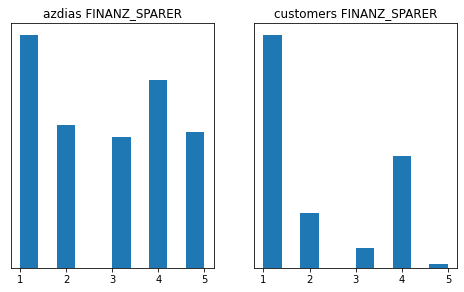

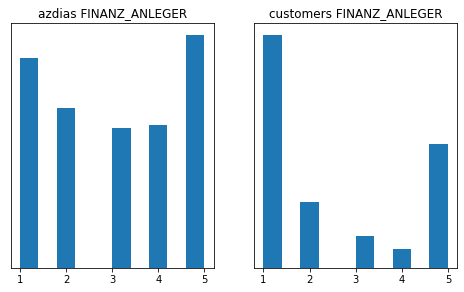

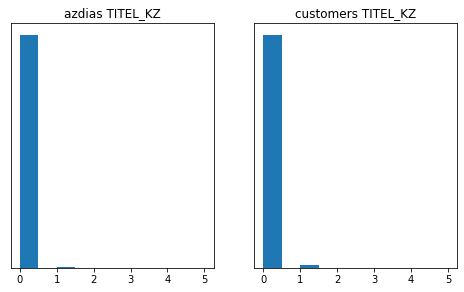

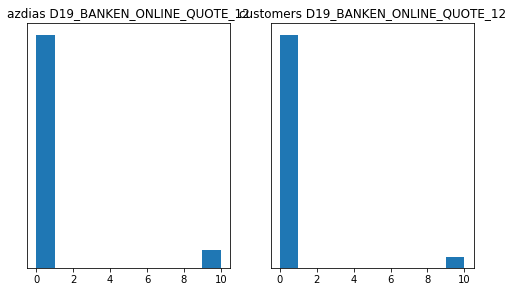

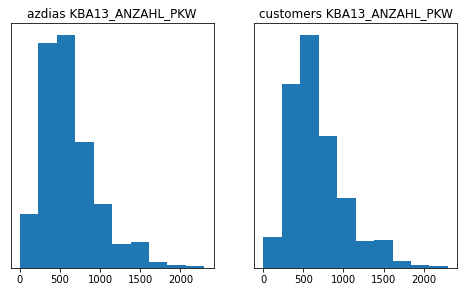

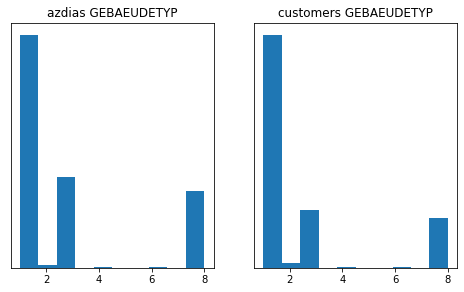

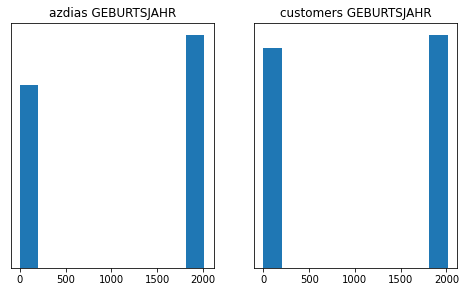

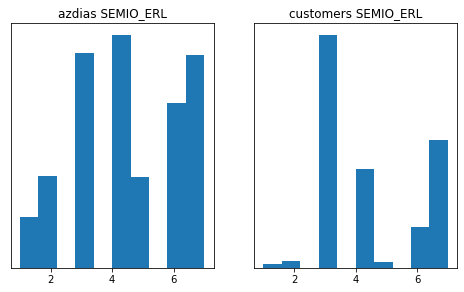

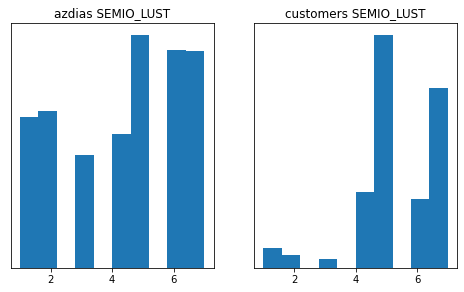

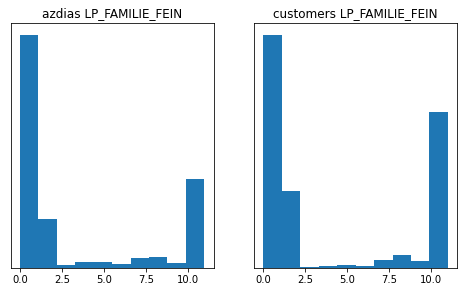

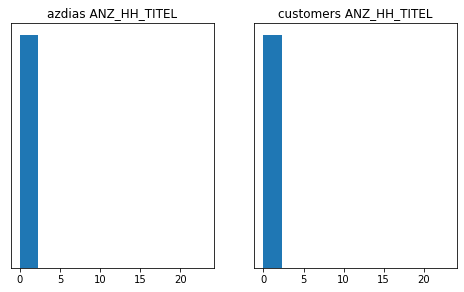

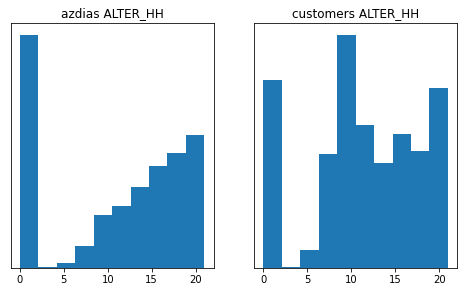

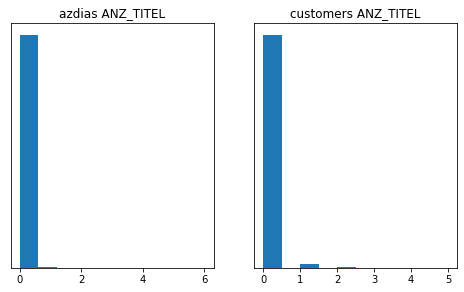

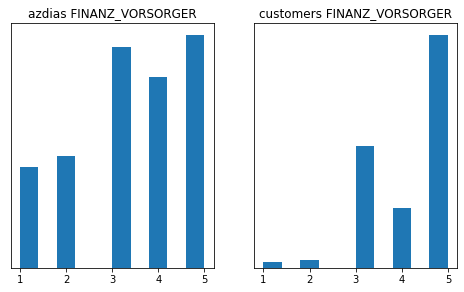

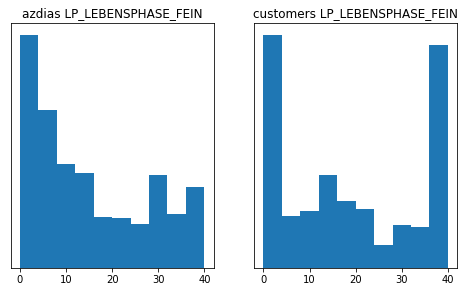

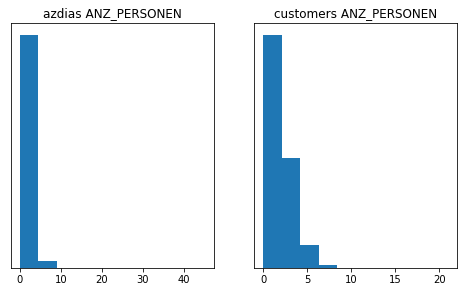

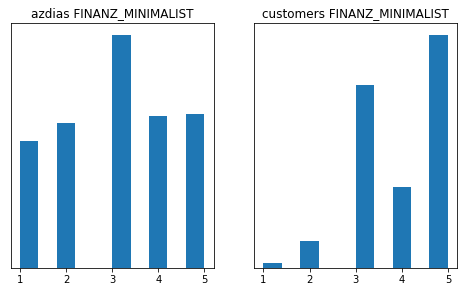

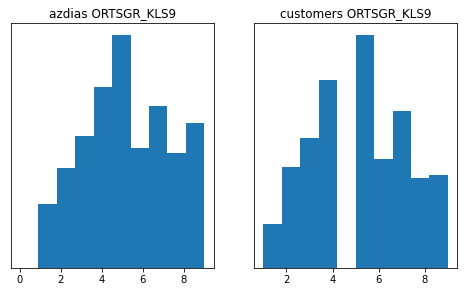

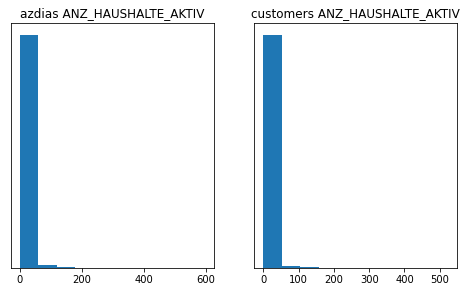

In [19]:
compare_plot_diff_features(azdias, 'azdias', customers, 'customers', diff_features)

From the comparing data distribution plot above, we can cleary see the difference in data distribution of the nominal and oridnal data between azdias and customers. (Except for those of interval data which is passed the screening process easily by not having the same value set since it is an interval data).  

We will use these features and extract its latent behavior using unsupervised model.

## Cleaning the data. 
In this phase, I will clean the data using these following steps. 

1. Extract only the selected feature from diff_feature and filter too much missing feature  
2. Encode missing value to np.nan. 
3. Impute missing value with median, since all the feature are of type integer.  
3. Encode nominal value with one hot encoder. 
4. Compose the three above steps with pipeline using sklearn

In [20]:
# identify selected features
selected_features = list(set(diff_features) - set(azdias_miss_features) - set(customer_miss_features))

In [21]:
# save selected features as json
CLEAN_DATA_DIR = Path('./clean-data')

with open(CLEAN_DATA_DIR / 'selected_features.json', 'w') as fp:
    json.dump(selected_features, fp)

In [136]:
from importlib import reload

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
import py_modules.custom_sklearn as csk
from py_modules.custom_sklearn import NominalEncoderAndMinMaxScaler, SelectColumnsTransformer, EncodeUnknownTransformer, PandasMedianImputer

In [137]:
reload(py_modules.custom_sklearn)

<module 'py_modules.custom_sklearn' from '/Users/boonchuay/Documents_2/temp/capstone-arvato-customer-segmentation/py_modules/custom_sklearn.py'>

In [132]:
# get list of nominal feature in selected_features
nominal_features = [*map(lambda meta: meta['feature'], metadata['nominal-data'])]
selected_nominal_features = [*filter(
    lambda feature: feature in nominal_features,
    selected_features
    )]

# get list of non-nominal feature
selected_non_nom_features = [*filter(lambda feature: feature not in selected_nominal_features, selected_features)]

print(selected_nominal_features)
print(selected_non_nom_features)

['GEBAEUDETYP', 'LP_LEBENSPHASE_FEIN', 'LP_FAMILIE_FEIN']
['FINANZ_VORSORGER', 'ORTSGR_KLS9', 'ANZ_HAUSHALTE_AKTIV', 'KBA13_ANZAHL_PKW', 'ANZ_HH_TITEL', 'SEMIO_ERL', 'GEBURTSJAHR', 'FINANZ_SPARER', 'D19_BANKEN_ONLINE_QUOTE_12', 'FINANZ_MINIMALIST', 'ANZ_PERSONEN', 'FINANZ_ANLEGER', 'SEMIO_LUST', 'ANZ_TITEL']


In [138]:
enc = py_modules.custom_sklearn.NominalEncoderAndMinMaxScaler(selected_nominal_features, selected_non_nom_features)

In [139]:
enc.fit(azdias[selected_features].dropna())

NominalEncoderAndMinMaxScaler(nominal_col=['GEBAEUDETYP', 'LP_LEBENSPHASE_FEIN',
                                           'LP_FAMILIE_FEIN'],
                              non_nominal_col=['FINANZ_VORSORGER',
                                               'ORTSGR_KLS9',
                                               'ANZ_HAUSHALTE_AKTIV',
                                               'KBA13_ANZAHL_PKW',
                                               'ANZ_HH_TITEL', 'SEMIO_ERL',
                                               'GEBURTSJAHR', 'FINANZ_SPARER',
                                               'D19_BANKEN_ONLINE_QUOTE_12',
                                               'FINANZ_MINIMALIST',
                                               'ANZ_PERSONEN', 'FINANZ_ANLEGER',
                                               'SEMIO_LUST', 'ANZ_TITEL'])

In [ ]:
enc.transform(azdias[selected_features].dropna()).info()

In [116]:
pipe = Pipeline([
    ('select_column', SelectColumnsTransformer(selected_features)),
    ('encode_unk', EncodeUnknownTransformer(feature2unk)),
    ('median_impute', PandasMedianImputer()),
    ('scaler', NominalEncoderAndMinMaxScaler(selected_nominal_features, selected_non_nom_features))
])

In [118]:
pipe.fit_transform(azdias)

AttributeError: 'NoneType' object has no attribute 'info'

### finalize the selecting feature

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')